In [99]:
import catboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from collections import Counter

In [100]:
#Читаем данные

train_old = pd.read_csv('train.csv', sep=';')
X_train = train_old.iloc[:, :-1]
Y_train = train_old.iloc[:, -1]
X_test = pd.read_csv('test.csv', sep=';')

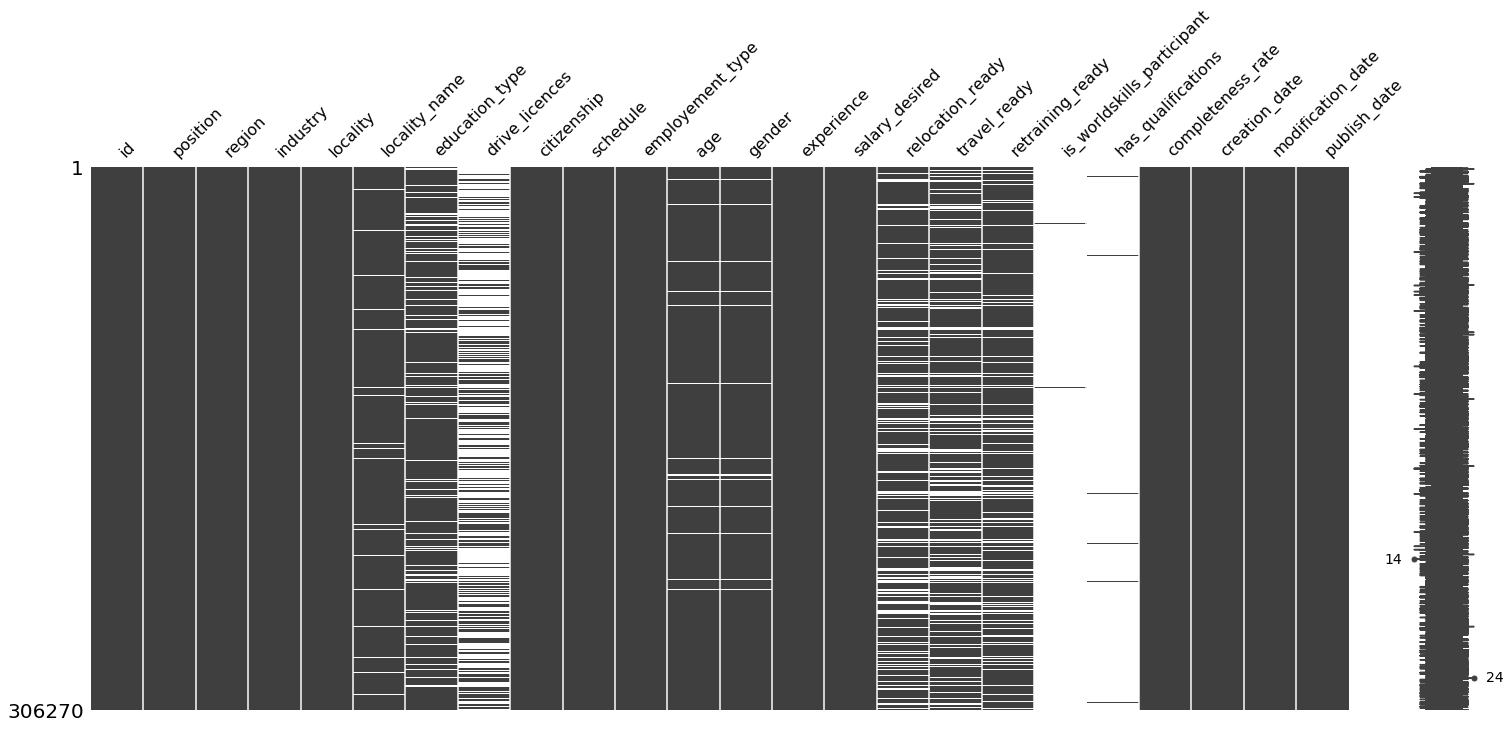

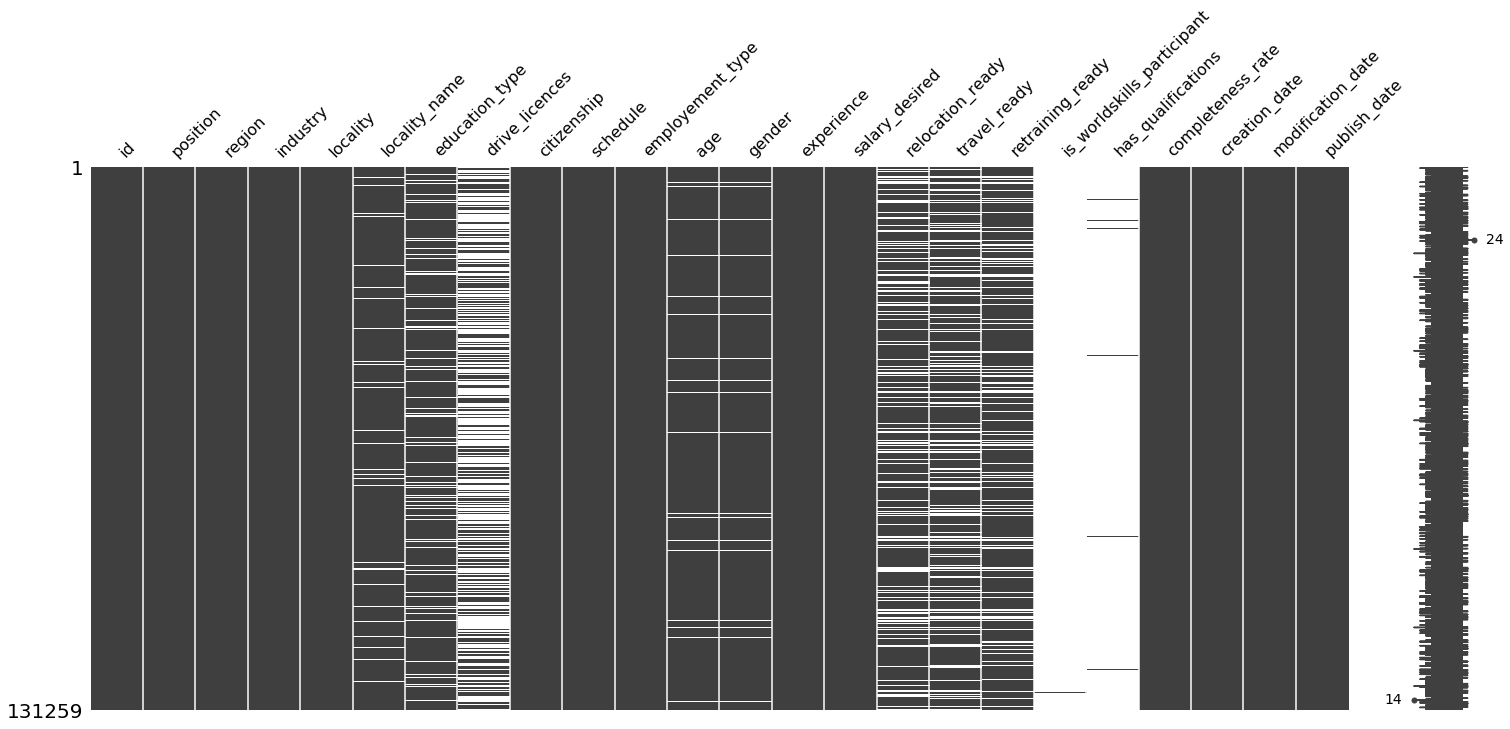

In [101]:
#Посмотрим на пропущенные значения

msno.matrix(X_train)
msno.matrix(X_test)

In [102]:
print(X_train.isna().sum())
print('-'*100)
print(X_test.isna().sum())

id                                 0
position                           0
region                            12
industry                           0
locality                           0
locality_name                  15492
education_type                 40032
drive_licences                184345
citizenship                        0
schedule                           0
employement_type                   0
age                             7811
gender                          7773
experience                         0
salary_desired                     0
relocation_ready               72703
travel_ready                   69216
retraining_ready               57126
is_worldskills_participant    306076
has_qualifications            303736
completeness_rate                  0
creation_date                      7
modification_date                  7
publish_date                       0
dtype: int64
---------------------------------------------------------------------------------------------------

In [103]:
#Поставим штраф на NaN и выбросим некоторые данные

X_train_new = X_train.fillna(-999, inplace=True)
X_train_new = X_train.drop(['is_worldskills_participant','has_qualifications', 'locality_name', 'creation_date','modification_date'], axis=1)
X_test_new = X_test.fillna(-999, inplace=True)
X_test_new = X_test.drop(['is_worldskills_participant','has_qualifications', 'locality_name', 'creation_date','modification_date'], axis=1)

In [104]:
#Сделаем препроцессинг колонки publish_date, и оставим там только год

X_train_new.publish_date = X_train_new.publish_date.apply(lambda x: x[:4])
X_test_new.publish_date = X_test_new.publish_date.apply(lambda x: x[:4])
X_train_new

,id,position,region,industry,locality,education_type,drive_licences,citizenship,schedule,employement_type,age,gender,experience,salary_desired,relocation_ready,travel_ready,retraining_ready,completeness_rate,publish_date
0,0,Специалист,Тульская область,"Государственная служба, некоммерческие организ...",7100000100000,Незаконченное высшее,[B],Российская Федерация,Полный рабочий день,Полная занятость,21.0,Мужской,3,35000,False,False,True,64.0,2020
1,1,Лаборант,Алтайский край,"Государственная служба, некоммерческие организ...",2200000100000,Высшее,[B],Российская Федерация,Полный рабочий день,Полная занятость,26.0,Женский,4,15000,False,True,True,88.0,2020
2,3,"Специалист, администратор, бухгалтер, экономист",Ульяновская область,"Административная работа, секретариат, АХО",7300000200000,Высшее,[B],Российская Федерация,Полный рабочий день,Полная занятость,36.0,Женский,12,20000,False,-999,True,78.0,2020
3,4,Специалист,Свердловская область,"Государственная служба, некоммерческие организ...",6600002300000,Высшее,[B],Российская Федерация,Полный рабочий день,Полная занятость,34.0,Женский,9,30000,False,False,False,91.0,2020
4,5,Инструктор по плаванию,Иркутская область,"Здравоохранение, спорт, красота, социальное об...",3800000400000,-999,-999,Российская Федерация,Полный рабочий день,Полная занятость,25.0,Мужской,1,40000,False,-999,-999,58.0,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306265,437521,Продавец консультант.,Забайкальский край,"Продажи, закупки, снабжение, торговля",7500100000200,Среднее,-999,Российская Федерация,"Полный рабочий день,Сменный график",Полная занятость,22.0,Мужской,0,25000,False,False,False,66.0,2020
306266,437522,менеджер,Тюменская область,"Государственная служба, некоммерческие организ...",7201100100000,Высшее,"[B, C]",Российская Федерация,Полный рабочий день,Полная занятость,24.0,Мужской,1,25000,False,True,True,68.0,2020
306267,437523,Руководитель,Калининградская область,Юриспруденция,3900600100000,Высшее,[B],Российская Федерация,Полный рабочий день,Полная занятость,38.0,Женский,0,40009,-999,True,True,58.0,2016
306268,437524,инженер,Ивановская область,Производство,3700000100000,Высшее,[B],Российская Федерация,Полный рабочий день,Полная занятость,40.0,Женский,4,30000,False,False,True,78.0,2020


In [91]:
#Делим выборку на train и validation 

X_train, x_validation, y_train, y_validation = train_test_split(X_train_new, Y_train, train_size=0.75, random_state=42)

In [92]:
#Строим модель на основе кэтбуста

cat_features = X_train_new[['position','region','industry', 'locality','education_type','drive_licences','citizenship','schedule','employement_type', 'gender', 'relocation_ready','travel_ready',
                            'retraining_ready', 'publish_date']]
model = CatBoostRegressor(loss_function = 'MAE', learning_rate=0.03, iterations=2000)
model.fit(X_train_new, Y_train, cat_features=cat_features, use_best_model=True, eval_set=(x_validation, y_validation),  plot=True, verbose=50)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 19506.0268428	test: 19502.7636716	best: 19502.7636716 (0)	total: 790ms	remaining: 26m 20s
50:	learn: 15410.2479472	test: 15303.8573257	best: 15303.8573257 (50)	total: 29.9s	remaining: 19m 1s
100:	learn: 14688.0616015	test: 14409.3568080	best: 14409.3568080 (100)	total: 1m 1s	remaining: 19m 20s
150:	learn: 14517.0362749	test: 14235.9481402	best: 14235.9481402 (150)	total: 1m 33s	remaining: 19m 4s
200:	learn: 14434.3199392	test: 14103.5198922	best: 14103.5198922 (200)	total: 2m 6s	remaining: 18m 54s
250:	learn: 14383.0226328	test: 13965.0952404	best: 13965.0952404 (250)	total: 2m 41s	remaining: 18m 44s
300:	learn: 14348.3896908	test: 13912.1777798	best: 13912.1777798 (300)	total: 3m 14s	remaining: 18m 15s
350:	learn: 14321.3683066	test: 13866.1098450	best: 13866.1098450 (350)	total: 3m 47s	remaining: 17m 47s
400:	learn: 14296.1045418	test: 13828.7208122	best: 13828.7208122 (400)	total: 4m 21s	remaining: 17m 21s
450:	learn: 14270.4007313	test: 13774.1134359	best: 13774.1134359 (

In [93]:
model.get_best_score()

{'learn': {'MAE': 13981.101741755101},
 'validation': {'MAE': 13404.832531592718}}

In [94]:
y_pred = model.predict(X_test_new)
y_pred

array([29202.87783459, 58204.77289704, 40066.75410111, ...,
       41062.53260822, 33298.63515032, 17361.39845354])

In [95]:
solution = X_test[['id']].copy()
solution['salary']= pd.Series(np.full(len(X_test), y_pred))
solution

,id,salary
0,2,29202.877835
1,6,58204.772897
2,7,40066.754101
3,11,27061.692435
4,16,54232.173633
...,...,...
131254,437515,16887.836458
131255,437518,22965.085678
131256,437526,41062.532608
131257,437527,33298.635150


In [98]:
solution.to_csv('solution_MAE_Year.csv', sep=',', index=False)